# Scattershot Boson Sampling

Implementation of [this paper](https://arxiv.org/pdf/1305.4346.pdf) in Strawberry Fields.

As we have seen in the Boson Sampling (BS) tutorial, a boson sampler is a quantum machine that takes a deterministic input made of $m$ modes, $n$ of them sending photons simultaneously through an interferometer modeled by a unitary matrix $U$. The output of the interferometer is a random distribution of photons that can be computed classically with the permanent of $U$. 

Scattershot Boson Sampling (SBS) was motivated by the fact that emitting $n$ photons simultaneously in the input is experimentally very hard to realize for large $n$. What is simpler to build is a random input using Spontaneous Parametric Down-Conversion (SPDC), whose distribution is given by $P(k_i = k)=(1-\chi^2) \chi^{2 k}$ where $k_i$ is the number of photon in mode i and $\chi \in (-1,1)$ is a given parameter (equation (7) of the paper). The advantage of SPDC is not only that it's a coherent source of photons but also that it always emit an even number of photons: one that can be used in a boson sampling circuit and one to measure the input.

In quantum optics, we model SPDC by 2-mode squeezing gates $\hat{S}_2$ such that $\hat{S}_2 |0 \rangle |0 \rangle = (1-\chi^2) \sum_{k=0}^{\infty} \chi^k |k \rangle |k \rangle$ (equation (3) of the paper). The first qubit will be used to measure the input while the second will be sent to the circuit. 

In SF, this 2-mode squeezing gate is called S2gate and takes as input a squeezing parameter $r$ related to $\chi$ by the formula $r=\tanh(\chi)$

In [165]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import factorial, tanh
import itertools

import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

import strawberryfields as sf
from strawberryfields.ops import *

In [93]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Compute the circuit

### Constants

In [2]:
r_squeezing = 0.4 # squeezing parameter for the S2gate
cutoff = 7 # max number of photons computed per mode

In [3]:
# arguments of the boson sampler
R_args = [0.5719, -1.9782, 2.0603, 0.0644]
BS_args = [(0.7804, 0.8578),
             (0.06406, 0.5165), 
             (0.473, 0.1176), 
             (0.563, 0.1517), 
             (0.1323, 0.9946), 
             (0.311, 0.3231),
             (0.4348, 0.0798),
             (0.4368, 0.6157)]

### Circuit

In [4]:
eng, q = sf.Engine(8)

In [5]:
with eng:
    # the first 4 qubits are used for input and the other 4 for output.
    S2gate(r_squeezing) | (q[0], q[4])
    S2gate(r_squeezing) | (q[1], q[5])
    S2gate(r_squeezing) | (q[2], q[6])
    S2gate(r_squeezing) | (q[3], q[7])

    Rgate(R_args[0])  | q[4]
    Rgate(R_args[1])  | q[5]
    Rgate(R_args[2])  | q[6]
    Rgate(R_args[3])  | q[7]

    BSgate(*BS_args[0]) | (q[4], q[5])
    BSgate(*BS_args[1]) | (q[6], q[7])
    BSgate(*BS_args[2]) | (q[5], q[6])
    BSgate(*BS_args[3]) | (q[4], q[5])
    BSgate(*BS_args[4]) | (q[6], q[7])
    BSgate(*BS_args[5]) | (q[5], q[6])
    BSgate(*BS_args[6]) | (q[4], q[5])
    BSgate(*BS_args[7]) | (q[6], q[7])

### Running

In [6]:
state = eng.run('fock', cutoff_dim=cutoff)

In [7]:
probs = state.all_fock_probs()

In [8]:
probs = probs.reshape(*[cutoff]*8) # reshape s.t. probs[k_1, k_2,...] gives the proba of the state (k_1, k_2,...)

In [9]:
np.sum(probs)

0.9989216634535326

## Analysis

### Get the unitary matrix
See [Boson Sampling tutorial](https://strawberryfields.readthedocs.io/en/latest/tutorials/tutorial_boson_sampling.html#boson-tutorial)

In [10]:
R = np.diag([np.exp(R_args[0]*1j),np.exp(R_args[1]*1j),np.exp(R_args[2]*1j),np.exp(R_args[3]*1j)])

In [11]:
def get_BS_matrix(theta, phi):
    return [[np.cos(theta), - np.exp(-1j * phi) * np.sin(theta)], [np.exp(1j * phi) * np.sin(theta), np.cos(theta)]]

In [12]:
BS_matrices = np.array([get_BS_matrix(theta, phi) for (theta,phi) in BS_args])

In [13]:
UBS1 = sp.linalg.block_diag(*BS_matrices[0:2])
UBS2 = sp.linalg.block_diag([[1]], BS_matrices[2], [[1]])
UBS3 = sp.linalg.block_diag(*BS_matrices[3:5])
UBS4 = sp.linalg.block_diag([[1]], BS_matrices[5], [[1]])
UBS5 = sp.linalg.block_diag(*BS_matrices[6:8])

In [14]:
U = np.linalg.multi_dot([UBS5, UBS4, UBS3, UBS2, UBS1, R])

### Compute the theoretical probability

We use mostly the section V of [this paper](https://arxiv.org/pdf/1212.2240.pdf) as well as [Boson Sampling tutorial](https://strawberryfields.readthedocs.io/en/latest/tutorials/tutorial_boson_sampling.html#boson-tutorial)

In [15]:
def perm(M):
    n_output = M.shape[0]
    n_input = M.shape[1]
    if n_output != n_input: # no conservation of photon number
        return 0
    n = n_input
    if n == 0:
        return 1
    d = np.ones(n)
    j =  0
    s = 1
    f = np.arange(n)
    v = M.sum(axis=0)
    p = np.prod(v)
    while (j < n-1):
        v -= 2*d[j]*M[j]
        d[j] = -d[j]
        s = -s
        prod = np.prod(v)
        p += s*prod
        f[0] = 0
        f[j] = f[j+1]
        f[j+1] = j+1
        j = f[0]    
    
    return p/2**(n-1)

In [16]:
def get_proba_output(U, input, output):
    list_rows = sum([[i] * output[i] for i in range(len(output))],[])
    list_columns = sum([[i] * input[i] for i in range(len(input))],[])
    U_st = U[:,list_columns][list_rows,:]
    perm_squared = np.abs(perm(U_st))**2
    denominator = np.prod([factorial(inp) for inp in input]) * np.prod([factorial(out) for out in output])
    return perm_squared / denominator

In [17]:
def get_proba_input(input):
    chi = np.tanh(r_squeezing)
    n = np.sum(input)
    m = len(input)
    return (1 - chi**2)**m * chi**(2*n) # equation (7) of the original paper

In [18]:
def get_proba(U, result):
    input, output = result[0:4], result[4:8]
    return get_proba_output(U, input, output) * get_proba_input(input) # P(O) = P(O|I) P(I)

## Compare the simulation with the theory

In [19]:
print(get_proba(U, [0,0,0,0,0,0,0,0]))
print(probs[0,0,0,0,0,0,0,0])

0.535996373869716
0.5359963738697161


In [20]:
print(get_proba(U, [1,0,0,0,1,0,0,0]))
print(probs[1,0,0,0,1,0,0,0])

0.008821826459915328
0.008821826459915326


## Visualization

### Make the probabilities sum to 1
Due to computational issues, the sum of the probability does not equal 1. Since it prevents us from sampling correctly, we choose to add the missing weight to the outcome [0,0,0,0, 0,0,0,0]

In [68]:
probs[0,0,0,0, 0,0,0,0] += 1 - np.sum(probs)

In [69]:
np.sum(probs)

1.0

### Sample

In [168]:
list_choices = list(itertools.product(*[range(cutoff)]*8))
list_choices[0]

(0, 0, 0, 0, 0, 0, 0, 0)

In [169]:
list_probs = [probs[list_choices[i]] for i in range(len(list_choices))]

In [170]:
choice = list_choices[np.random.choice(range(len(list_choices)), p=list_probs)]

### Visualize

(-0.05, 1.05, -0.025, 0.525)

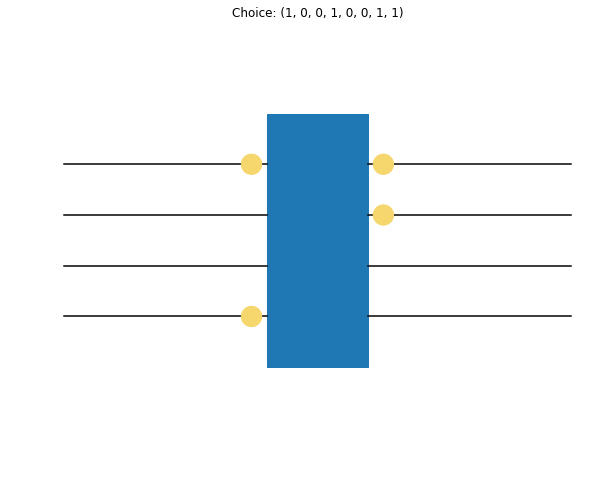

In [196]:
# Constants

color_rect = colormap[0]
color_lines = "black"
color_photons = "#F5D76E"
radius_photons = 0.02
margin_photons = 0.01
x_begin_rect, x_end_rect = 0.4, 0.6

# Sample

choice = list_choices[np.random.choice(range(len(list_choices)), p=list_probs)]

# Plot

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

rect = mpatches.Rectangle((x_begin_rect,0),x_end_rect-x_begin_rect, 0.5,edgecolor=color_rect,facecolor=color_rect)
ax.add_patch(rect)

for i_line, y_line in enumerate(np.linspace(0.1,0.4,4), 0):
    # draw the lines
    plt.plot([0,x_begin_rect], [y_line,y_line], color=color_lines)
    plt.plot([x_end_rect, 1], [y_line,y_line], color=color_lines)

    # draw the input photons
    for i_photon in range(choice[i_line]):
        x_photon = x_begin_rect - margin_photons - radius_photons - i_photon*(radius_photons*2 + margin_photons)
        circle = mpatches.Circle([x_photon,y_line], radius_photons, color=color_photons, zorder=3)
        ax.add_patch(circle)
    
    # draw the output photons
    for i_photon in range(choice[4 + i_line]):
        x_photon = x_end_rect + margin_photons + radius_photons + i_photon*(radius_photons*2 + margin_photons)
        circle = mpatches.Circle([x_photon,y_line], radius_photons, color=color_photons, zorder=3)
        ax.add_patch(circle)
        
plt.title("Choice: {}".format(choice))
plt.axis('equal')
plt.axis('off')